Newton  0: |A+|=     0, |A-|=     0, |A|=     0
         CG iters=8866, relres=1.95e-06, step=11.72s
Newton  1: |A+|= 34800, |A-|=     0, |A|= 34800
         CG iters=2531, relres=1.92e-06, step=3.69s
Newton  2: |A+|= 19430, |A-|=     0, |A|= 19430
         CG iters=1484, relres=1.99e-06, step=2.10s
Newton  3: |A+|= 18828, |A-|=     0, |A|= 18828
         CG iters=1979, relres=1.98e-06, step=2.63s
Newton  4: |A+|= 18183, |A-|=     0, |A|= 18183
         CG iters=2031, relres=1.97e-06, step=2.40s
Newton  5: |A+|= 17672, |A-|=     0, |A|= 17672
         CG iters=1696, relres=1.97e-06, step=2.73s
Newton  6: |A+|= 17639, |A-|=     0, |A|= 17639
         CG iters=2160, relres=2.00e-06, step=2.87s
Newton  7: |A+|= 16774, |A-|=     0, |A|= 16774
         CG iters=1783, relres=2.00e-06, step=2.05s
Newton  8: |A+|= 16691, |A-|=     0, |A|= 16691
         CG iters=2250, relres=2.00e-06, step=2.70s
Newton  9: |A+|= 15965, |A-|=     0, |A|= 15965
         CG iters=1914, relres=1.98e-06, step=1.95s

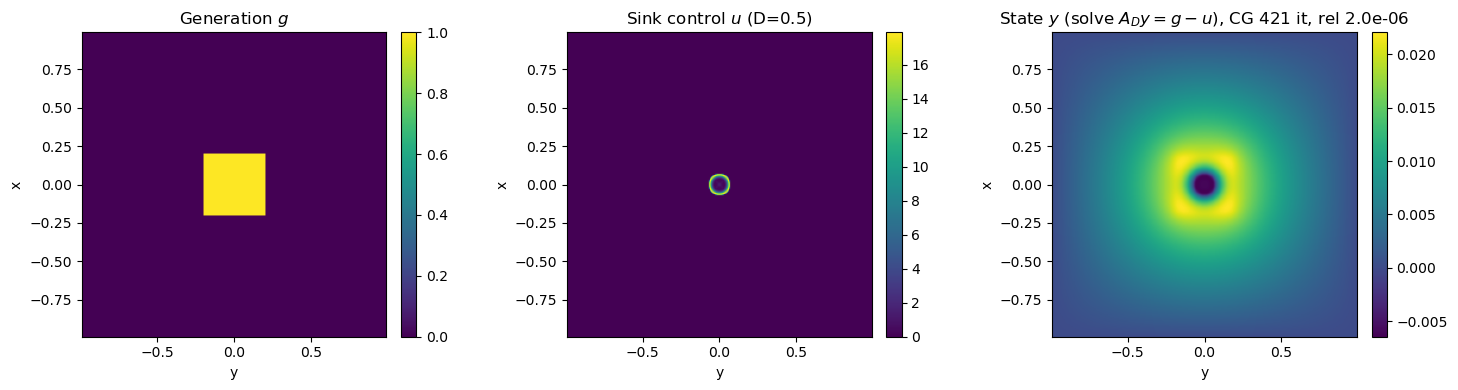

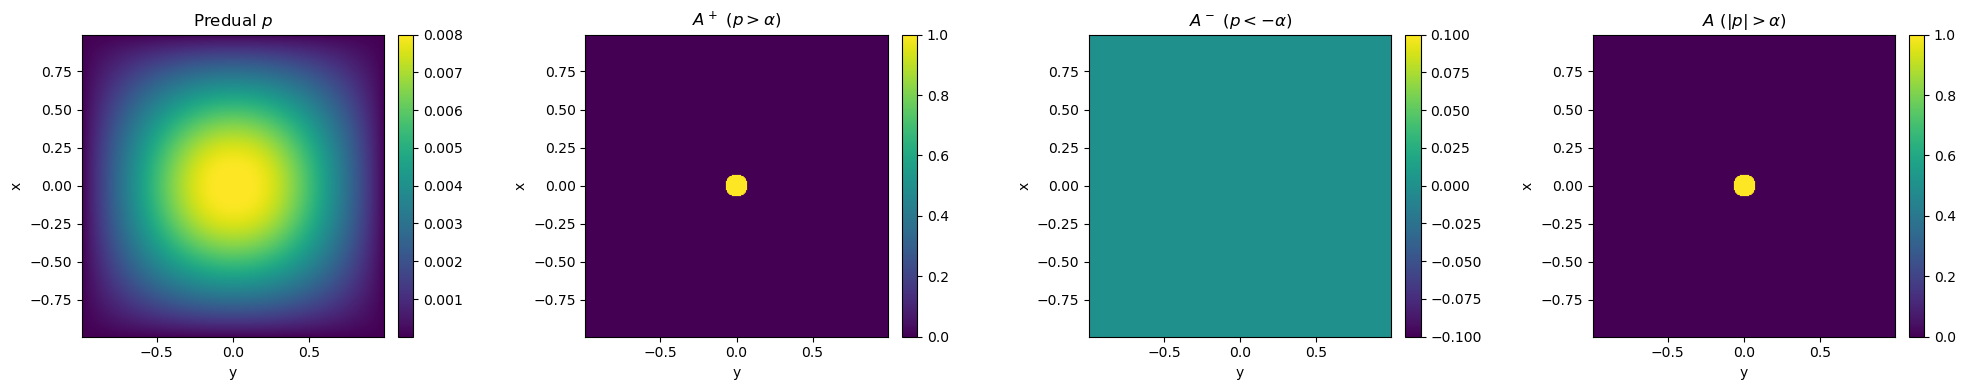

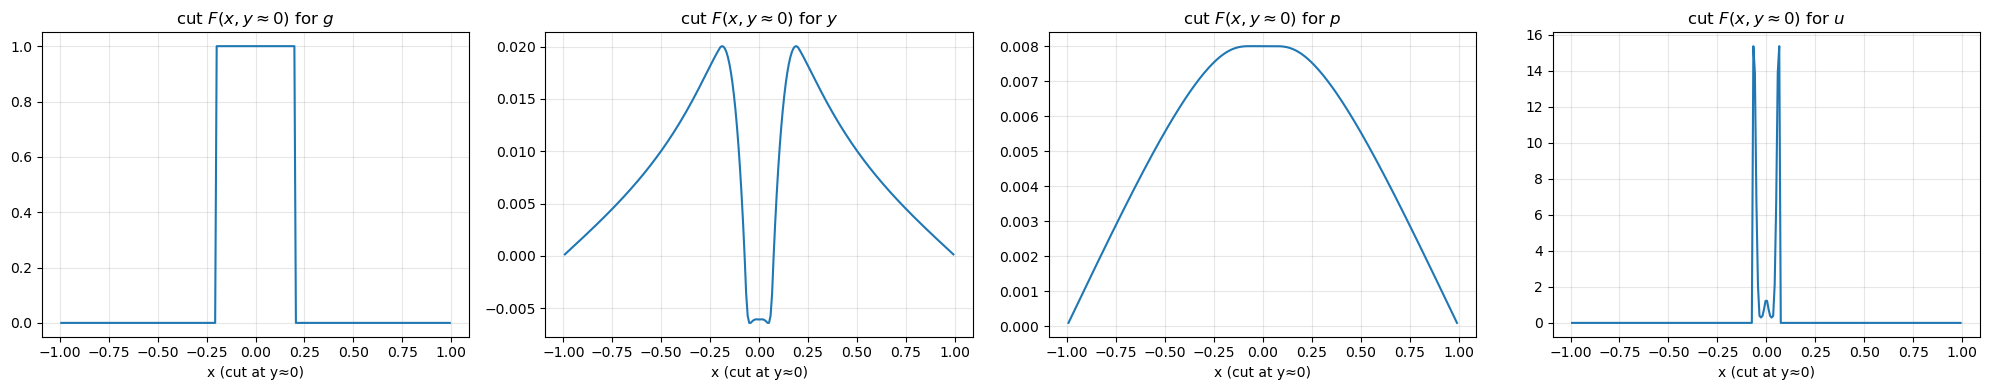

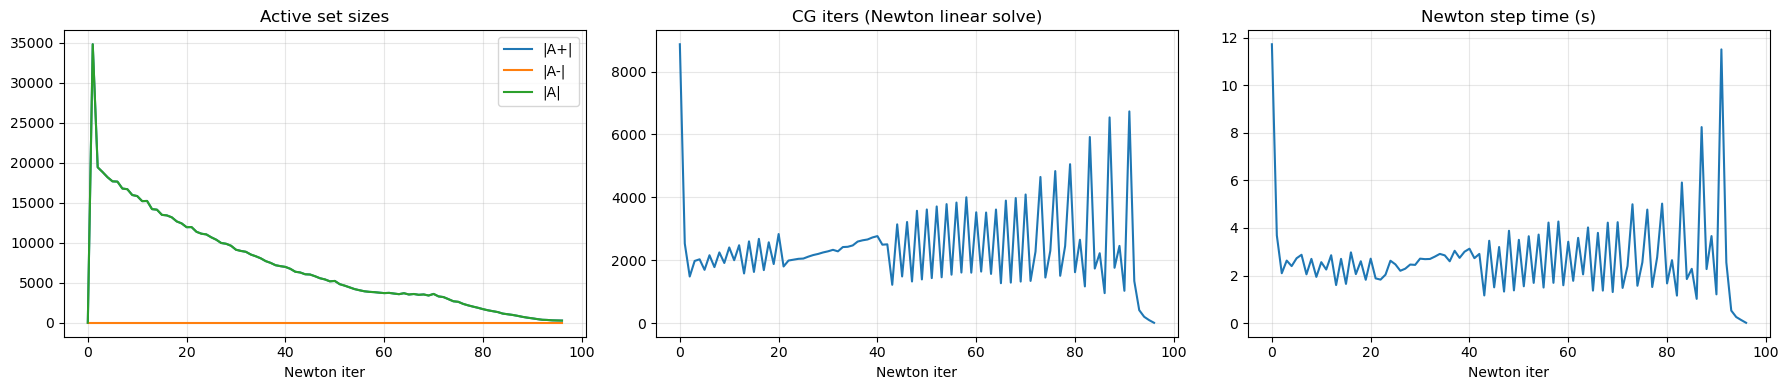

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================================================
# Species pool with sinks (control) + generation (source)
# ============================================================
# PDE:         A_D y = g - u        in Ω,  y=0 on ∂Ω
# Tracking:    z ≡ 0, minimize 1/2||y - z||^2 + α||u||_M
#
# Predual MY semismooth Newton:
#   Solve:  A_D^2 p + λ(p) = g
#   where:  λ(p) = max(0, c(p-α)) + min(0, c(p+α))
#   then:   u = λ(p)
#           y solves A_D y = g - u
#
# Domain: Ω = [-1,1]^2, Dirichlet boundary, N×N interior grid
# A_D = -DΔ (constant D>0), discretized by 5-point stencil for -Δ.
# ============================================================


# -----------------------------
# Grid and indicator squares
# -----------------------------
def make_grid(N, a=-1.0, b=1.0):
    h = (b - a) / (N + 1)
    x = a + h * np.arange(1, N + 1)
    y = a + h * np.arange(1, N + 1)
    X, Y = np.meshgrid(x, y, indexing="ij")
    return X, Y, h

def square_indicator(X, Y, halfwidth=0.5):
    return ((np.abs(X) < halfwidth) & (np.abs(Y) < halfwidth)).astype(float)

def generation_g(X, Y, g0=1.0):
    # g = g0 on central square, 0 outside
    return g0 * square_indicator(X, Y, halfwidth=0.2)

def target_z(X, Y):
    # Option A: z ≡ 0 (remove species everywhere)
    return np.zeros_like(X, dtype=float)


# -----------------------------
# Discrete operator A = -Δ (Dirichlet) and diffusion scaling A_D = D*A
# -----------------------------
def apply_A(u, h):
    N = u.shape[0]
    up = np.zeros((N + 2, N + 2), dtype=u.dtype)
    up[1:-1, 1:-1] = u
    return (
        4.0 * up[1:-1, 1:-1]
        - up[2:, 1:-1]
        - up[:-2, 1:-1]
        - up[1:-1, 2:]
        - up[1:-1, :-2]
    ) / (h * h)

def apply_AD(u, h, D):
    return D * apply_A(u, h)

def apply_AD2(u, h, D):
    # A_D^2 = (D*A)(D*A) = D^2 * A^2
    return apply_AD(apply_AD(u, h, D), h, D)


# -----------------------------
# Matrix-free Conjugate Gradient (SPD)
# -----------------------------
def cg(apply_op, b, x0=None, tol=1e-6, maxiter=200):
    x = np.zeros_like(b) if x0 is None else x0.copy()
    r = b - apply_op(x)
    p = r.copy()
    rr_old = float(np.vdot(r, r))
    b_norm = np.sqrt(float(np.vdot(b, b))) + 1e-30

    for k in range(maxiter):
        Ap = apply_op(p)
        pAp = float(np.vdot(p, Ap))
        if pAp <= 0:
            break
        alpha = rr_old / pAp
        x += alpha * p
        r -= alpha * Ap
        rr_new = float(np.vdot(r, r))
        rel = np.sqrt(rr_new) / b_norm
        if rel < tol:
            return x, k + 1, rel
        beta = rr_new / rr_old
        p = r + beta * p
        rr_old = rr_new

    return x, maxiter, np.sqrt(rr_old) / b_norm


# -----------------------------
# State solve: A_D y = rhs
# -----------------------------
def solve_state(rhs, h, D, tol=1e-6, maxiter=800, x0=None):
    def apply_lin(y):
        return apply_AD(y, h, D)
    return cg(apply_lin, rhs, x0=x0, tol=tol, maxiter=maxiter)


# -----------------------------
# Moreau–Yosida map λ(p) and semismooth Newton
# -----------------------------
def lambda_MY(p, alpha, c):
    # λ(p) = max(0, c(p-α)) + min(0, c(p+α))
    return np.maximum(0.0, c * (p - alpha)) + np.minimum(0.0, c * (p + alpha))

def solve_sinks_with_generation(
    N=64,
    D=0.2,
    alpha=1e-3,
    c=1e7,
    g0=1.0,
    newton_maxiter=15,
    cg_tol=1e-6,
    cg_maxiter=200,
    verbose=True,
):
    """
    Solves:
        A_D^2 p + λ(p) = g
    via semismooth Newton active set, then:
        u = λ(p)
        A_D y = g - u
    """
    if D <= 0:
        raise ValueError("Diffusion coefficient D must be positive.")

    X, Y, h = make_grid(N)
    g = generation_g(X, Y, g0=g0)
    z = target_z(X, Y)  # unused in the reduced equation since z=0, kept for clarity

    p = np.zeros_like(g)
    Aplus_prev = None
    Aminus_prev = None

    hist = {"k": [], "Aplus": [], "Aminus": [], "cg_iters": [], "cg_relres": [], "sec": []}

    for k in range(newton_maxiter):
        t0 = time.time()

        Aplus = (p > alpha)
        Aminus = (p < -alpha)
        Aset = Aplus | Aminus

        if verbose:
            print(f"Newton {k:2d}: |A+|={Aplus.sum():6d}, |A-|={Aminus.sum():6d}, |A|={Aset.sum():6d}")

        if (Aplus_prev is not None
            and np.array_equal(Aplus, Aplus_prev)
            and np.array_equal(Aminus, Aminus_prev)):
            if verbose:
                print("Active sets unchanged -> terminate.")
            break

        Aplus_prev = Aplus.copy()
        Aminus_prev = Aminus.copy()

        # From: (A_D^2 + c*diag(Aset)) p = g + c*α*(chi_A+ - chi_A-)
        rhs = g + c * alpha * (Aplus.astype(float) - Aminus.astype(float))

        def apply_lin(x):
            return apply_AD2(x, h, D) + c * (Aset.astype(float) * x)

        p, iters, relres = cg(apply_lin, rhs, x0=p, tol=cg_tol, maxiter=cg_maxiter)

        t1 = time.time()
        hist["k"].append(k)
        hist["Aplus"].append(int(Aplus.sum()))
        hist["Aminus"].append(int(Aminus.sum()))
        hist["cg_iters"].append(int(iters))
        hist["cg_relres"].append(float(relres))
        hist["sec"].append(float(t1 - t0))

        if verbose:
            print(f"         CG iters={iters:4d}, relres={relres:.2e}, step={t1-t0:.2f}s")

    # Control u = λ(p)
    u = lambda_MY(p, alpha=alpha, c=c)

    # State y solves: A_D y = g - u
    rhs_state = g - u
    y, y_iters, y_rel = solve_state(rhs_state, h, D, tol=cg_tol, maxiter=800)

    return X, Y, h, g, z, p, u, y, (y_iters, y_rel), hist


# -----------------------------
# Plotting helpers
# -----------------------------
def imshow_field(ax, X, Y, F, title):
    extent = [Y.min(), Y.max(), X.min(), X.max()]
    im = ax.imshow(F, origin="lower", extent=extent, aspect="equal")
    ax.set_title(title)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    return im

def visualize_all(X, Y, g, p, u, y, alpha, D, state_info, hist, cut="y0"):
    # Row 1: g, u, y
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    im = imshow_field(axes[0], X, Y, g, r"Generation $g$")
    plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    im = imshow_field(axes[1], X, Y, u, rf"Sink control $u$ (D={D})")
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    iters, rel = state_info
    im = imshow_field(axes[2], X, Y, y, rf"State $y$ (solve $A_D y=g-u$), CG {iters} it, rel {rel:.1e}")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    plt.tight_layout()

    # Row 2: p and active sets
    Aplus = (p > alpha).astype(float)
    Aminus = (p < -alpha).astype(float)
    A = (np.abs(p) > alpha).astype(float)

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    im = imshow_field(axes[0], X, Y, p, r"Predual $p$")
    plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    im = imshow_field(axes[1], X, Y, Aplus, r"$A^+$ ($p>\alpha$)")
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    im = imshow_field(axes[2], X, Y, Aminus, r"$A^-$ ($p<-\alpha$)")
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    im = imshow_field(axes[3], X, Y, A, r"$A$ ($|p|>\alpha$)")
    plt.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
    plt.tight_layout()

    # Row 3: MIDLINE CUTS (instead of mean projections)
    # Choose indices closest to x=0 or y=0 for robustness
    ix0 = int(np.argmin(np.abs(X[:, 0])))  # row index where x is closest to 0
    iy0 = int(np.argmin(np.abs(Y[0, :])))  # col index where y is closest to 0

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))

    if cut == "y0":
        # cut at y≈0: vary x
        coord = X[:, 0]
        g_cut = g[:, iy0]
        y_cut = y[:, iy0]
        p_cut = p[:, iy0]
        u_cut = u[:, iy0]
        xlabel = "x (cut at y≈0)"
        suffix = r"$F(x, y\approx 0)$"
    elif cut == "x0":
        # cut at x≈0: vary y
        coord = Y[0, :]
        g_cut = g[ix0, :]
        y_cut = y[ix0, :]
        p_cut = p[ix0, :]
        u_cut = u[ix0, :]
        xlabel = "y (cut at x≈0)"
        suffix = r"$F(x\approx 0, y)$"
    else:
        raise ValueError("cut must be 'y0' or 'x0'.")

    axes[0].plot(coord, g_cut); axes[0].grid(True, alpha=0.3); axes[0].set_title(rf"cut {suffix} for $g$")
    axes[1].plot(coord, y_cut); axes[1].grid(True, alpha=0.3); axes[1].set_title(rf"cut {suffix} for $y$")
    axes[2].plot(coord, p_cut); axes[2].grid(True, alpha=0.3); axes[2].set_title(rf"cut {suffix} for $p$")
    axes[3].plot(coord, u_cut); axes[3].grid(True, alpha=0.3); axes[3].set_title(rf"cut {suffix} for $u$")

    for ax in axes:
        ax.set_xlabel(xlabel)
    plt.tight_layout()

    # Row 4: diagnostics
    if len(hist["k"]) > 0:
        k = np.array(hist["k"])
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        axes[0].plot(k, hist["Aplus"], label="|A+|")
        axes[0].plot(k, hist["Aminus"], label="|A-|")
        axes[0].plot(k, np.array(hist["Aplus"]) + np.array(hist["Aminus"]), label="|A|")
        axes[0].grid(True, alpha=0.3)
        axes[0].set_title("Active set sizes")
        axes[0].set_xlabel("Newton iter")
        axes[0].legend()

        axes[1].plot(k, hist["cg_iters"])
        axes[1].grid(True, alpha=0.3)
        axes[1].set_title("CG iters (Newton linear solve)")
        axes[1].set_xlabel("Newton iter")

        axes[2].plot(k, hist["sec"])
        axes[2].grid(True, alpha=0.3)
        axes[2].set_title("Newton step time (s)")
        axes[2].set_xlabel("Newton iter")
        plt.tight_layout()

    plt.show()



# ============================================================
# RUN (edit these parameters)
# ============================================================
N = 256          
D = 0.5         # diffusion coefficient
alpha = 8e-3
c = 1e8
g0 = 1.0        # generation intensity inside the square

newton_maxiter = 500
cg_tol = 2e-6
cg_maxiter = 12000

X, Y, h, g, z, p, u, y, state_info, hist = solve_sinks_with_generation(
    N=N, D=D, alpha=alpha, c=c, g0=g0,
    newton_maxiter=newton_maxiter,
    cg_tol=cg_tol, cg_maxiter=cg_maxiter,
    verbose=True
)

visualize_all(X, Y, g, p, u, y, alpha=alpha, D=D, state_info=state_info, hist=hist)
